In [19]:
# Import the library
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from functools import reduce
import matplotlib.pyplot as plt
import seaborn as sns
import re

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import scale
from sklearn.feature_selection import RFE
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline


In [20]:
# import the data file
def import_data(filename) :
  # TODO check is csv file or not or use try except block
  try:
    census_data = pd.read_csv(filename)
  return census_data

In [21]:
# Step 1 ans 2
# TODO do validation assert checks and error handling try except blocks
def findColumnD(census_data) :
  census_data1 = census_data.loc[:, ["Area_name", "STCOU"]]
  new_data = census_data.loc[:, census_data.columns[census_data.columns.str.endswith("D")]]
  combined_data = pd.concat([census_data1, new_data], axis = 1)
  melted_data = combined_data.melt(id_vars= ["Area_name", "STCOU"],value_name = "Enrollment")
  return melted_data

In [22]:
# Step 3
# TODO do validation assert checks and error handling try except blocks
def setYearColumn(melted_data) :
  melted_data['Year'] = 0
  melted_data['Measurement'] = ''
  for index, row in melted_data.iterrows():
      # Parse the string to extract year
      year = int(row['variable'][-3:-1])  # Extract the year from the string
      if year < 24 :
        year = 2000 + year
      else :
        year = 1900 + year
      measurement = row['variable'][:7]
      melted_data.at[index, 'Year'] = year
      melted_data.at[index, 'Measurement'] = measurement
      #print(melted_data)
      #melted_data = melted_data.drop('variable', axis = 0)
      #print(df.loc[:, ['Name', 'Age']])
  print (melted_data['Year'].unique())
  return melted_data



In [8]:
#filename_a = 'https://www4.stat.ncsu.edu/~online/datasets/EDU01a.csv'
#filename_b = 'https://www4.stat.ncsu.edu/~online/datasets/EDU01b.csv'
#census_data = import_data(filename_b)
#melted_data = findColumnD(census_data)
#print(melted_data["Enrollment"].unique())
#print(melted_data['Area_name'].unique())
#melted_data = setYearColumn(melted_data)
#melted_data.head()


In [23]:
def get_state_division(Area_name):\
    # Add your if/elif conditions for division classification
    # For example:
    if Area_name in ['CONNECTICUT', 'MAINE', 'MASSACHUSETTS', 'NEW HAMPSHIRE', 'RHODE ISLAND', 'VERMONT']:
        return 'Division 1'
    elif Area_name in ['NEW JERSEY', 'NEW YORK', ' PENNSYLVANIA']:
        return 'Division 2'
    elif Area_name in ['ILLINOIS', 'INDIANA', 'MICHIGAN', 'OHIO', 'WISCONSIN']:
        return 'Division 3'
    elif Area_name in ['IOWA', 'KANSAS', 'MINNESOTA', 'MISSOURI', 'NEBRASKA', 'NORTH DAKOTA', 'SOUTH DAKOTA']:
        return 'Division 4'
    elif Area_name in ['DELWARE', 'FLORIDA', 'GEORGIA', 'MARYLAND', 'NORTH CAROLINA', 'SOUTH CAROLINA', 'VIRGINIA', 'WASHINGTON', 'D.C.', 'WEST VIRGINIA']:
        return 'Division 5'
    elif Area_name in ['ALABAMA', 'KENTUCKY', 'MISSISSIPPI', 'TENNESSEE']:
        return 'Division 6'
    elif Area_name in ['ARKANSAS', 'LOUISIANA', 'OKLAHOMA', 'TEXAS']:
        return 'Division 7'
    elif Area_name in ['ARIZONA', 'COLORADO', 'IDAHO', 'MONTANA', 'NEVADA', 'NEW MEXICO', 'UTAH', 'WYOMING']:
        return 'Division 8'
    elif Area_name in ['ALASKA', 'CALIFORNIA','WASHINGTON', 'HAWAII', 'OREGON']:
        return 'Division 9'

    # If the state is not in any division, return 'ERROR'
    return 'ERROR'



In [24]:
# Step 5
def getCountyData(county_df) :
  # Extract the state abbreviation from the 'Area_name' column for county data
  county_df['StateAbbrev'] = county_df['Area_name'].apply(lambda x: x[-2:])

  # Display the updated county DataFrame
  #print(county_df)
  return county_df


In [25]:
# Step 6
def getNonCountyData(non_county_df) :
  # Vectorize the function for the entire DataFrame
  vectorized_get_state_division = np.vectorize(get_state_division)

  # Apply the vectorized function to the 'State_Abbreviation' column and create a new 'Division' column
  non_county_df['Division'] = vectorized_get_state_division(non_county_df['Area_name'])

  # Print or use the modified DataFrame as needed
  #print(non_county_df)
  return non_county_df

In [26]:

def getCountyNonCountyData(melted_data) :
  # Use the .apply() method with a lambda function to create an indexing vector
  indexing_vector = melted_data['Area_name'].apply(lambda x: ',' not in x)

  # Create two DataFrames based on the indexing vector
  non_county_df = melted_data[indexing_vector]
  county_df = melted_data[np.logical_not(indexing_vector)]

  county_df = getCountyData(county_df)
  non_county_df = getNonCountyData(non_county_df)

  return county_df, non_county_df

In [27]:
def data_wrapper(filename, enrollment_column='enrollment') :
  census_data = import_data(filename)
  melted_data = findColumnD(census_data)
  melted_data["Enrollment"].unique()
  melted_data.head()
  melted_data['Area_name'].unique()
  melted_data = setYearColumn(melted_data)
  county_df, non_county_df = getCountyNonCountyData(melted_data)
  return [county_df, non_county_df]


In [28]:
def combine_data(*data_sets):
    # Extract county and non-county data using map and lambda
    county_data_sets = map(lambda x: x[1], data_sets)
    non_county_data_sets = map(lambda x: x[0], data_sets)

    # Use reduce and pd.concat to combine county data sets
    combined_county_df = reduce(lambda x, y: pd.concat([x, y], ignore_index=True), county_data_sets)

    # Use reduce and pd.concat to combine non-county data sets
    combined_non_county_df = reduce(lambda x, y: pd.concat([x, y], ignore_index=True), non_county_data_sets)

    return [combined_non_county_df, combined_county_df]

In [29]:
# Call the wrapper function for both data sets
filename_a = 'https://www4.stat.ncsu.edu/~online/datasets/PST01a.csv'
filename_b = 'https://www4.stat.ncsu.edu/~online/datasets/PST01b.csv'
filename_c = 'https://www4.stat.ncsu.edu/~online/datasets/PST01c.csv'
filename_d = 'https://www4.stat.ncsu.edu/~online/datasets/PST01d.csv'


census_data_a = data_wrapper(filename_a, enrollment_column='enrollment')
census_data_b = data_wrapper(filename_b, enrollment_column='enrollment')
census_data_c = data_wrapper(filename_c, enrollment_column='enrollment')
census_data_d = data_wrapper(filename_d, enrollment_column='enrollment')

# Display the combined data
county_df, non_county_df = census_data_a
print(county_df.head())
print(non_county_df.head())

# Call the combine_data function to combine the results
combined_data = combine_data(census_data_a, census_data_b,census_data_c, census_data_d)

# Display the combined data
combined_non_county_df, combined_county_df = combined_data
print("Combined Non-County Data Frame:")
print(combined_non_county_df.head())

print("\nCombined County Data Frame:")
print(combined_county_df.head())

[1971 1972 1973 1974 1975 1976 1977 1978 1979 1981]


<ipython-input-24-997db1f8c05b>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  county_df['StateAbbrev'] = county_df['Area_name'].apply(lambda x: x[-2:])
<ipython-input-25-fbbb991562b1>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non_county_df['Division'] = vectorized_get_state_division(non_county_df['Area_name'])


[1982 1983 1984 1985 1986 1987 1988 1989 1990]


<ipython-input-24-997db1f8c05b>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  county_df['StateAbbrev'] = county_df['Area_name'].apply(lambda x: x[-2:])
<ipython-input-25-fbbb991562b1>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non_county_df['Division'] = vectorized_get_state_division(non_county_df['Area_name'])


[1991 1992 1993 1994 1995 1996 1997 1998 1999 2000]


<ipython-input-24-997db1f8c05b>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  county_df['StateAbbrev'] = county_df['Area_name'].apply(lambda x: x[-2:])
<ipython-input-25-fbbb991562b1>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non_county_df['Division'] = vectorized_get_state_division(non_county_df['Area_name'])


[2000 2001 2002 2003 2004 2005 2006 2007 2008 2009]
     Area_name  STCOU    variable  Enrollment  Year Measurement StateAbbrev
2  Autauga, AL   1001  PST015171D       25508  1971     PST0151          AL
3  Baldwin, AL   1003  PST015171D       60141  1971     PST0151          AL
4  Barbour, AL   1005  PST015171D       23092  1971     PST0151          AL
5     Bibb, AL   1007  PST015171D       13919  1971     PST0151          AL
6   Blount, AL   1009  PST015171D       27817  1971     PST0151          AL
         Area_name  STCOU    variable  Enrollment  Year Measurement  \
0    UNITED STATES      0  PST015171D   206827028  1971     PST0151   
1          ALABAMA   1000  PST015171D     3497452  1971     PST0151   
69          ALASKA   2000  PST015171D      316494  1971     PST0151   
99         ARIZONA   4000  PST015171D     1896108  1971     PST0151   
115       ARKANSAS   5000  PST015171D     1972028  1971     PST0151   

       Division  
0         ERROR  
1    Division 6  
69   Divisi

<ipython-input-24-997db1f8c05b>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  county_df['StateAbbrev'] = county_df['Area_name'].apply(lambda x: x[-2:])
<ipython-input-25-fbbb991562b1>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non_county_df['Division'] = vectorized_get_state_division(non_county_df['Area_name'])


In [30]:
# Call the wrapper function for both data sets
filename_a = 'https://www4.stat.ncsu.edu/~online/datasets/EDU01a.csv'
filename_b = 'https://www4.stat.ncsu.edu/~online/datasets/EDU01b.csv'

census_data_a = data_wrapper(filename_a, enrollment_column='enrollment')
census_data_b = data_wrapper(filename_b, enrollment_column='enrollment')
#print(census_data_a['Year'].unique())
#print(census_data_b['Year'].unique())
# Call the combine_data function to combine the results
combined_data = combine_data(census_data_a, census_data_b)

# Display the combined data
combined_non_county_df, combined_county_df = combined_data
print("Combined Non-County Data Frame:")
print(combined_non_county_df.head())

print("\nCombined County Data Frame:")
print(combined_county_df.head())



[1987 1988 1989 1990 1991 1992 1993 1994 1995 1996]


<ipython-input-24-997db1f8c05b>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  county_df['StateAbbrev'] = county_df['Area_name'].apply(lambda x: x[-2:])
<ipython-input-25-fbbb991562b1>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non_county_df['Division'] = vectorized_get_state_division(non_county_df['Area_name'])


[1997 1998 1999 2000 2001 2002 2003 2004 2005 2006]
Combined Non-County Data Frame:
     Area_name  STCOU    variable  Enrollment  Year Measurement StateAbbrev
0  Autauga, AL   1001  EDU010187D        6829  1987     EDU0101          AL
1  Baldwin, AL   1003  EDU010187D       16417  1987     EDU0101          AL
2  Barbour, AL   1005  EDU010187D        5071  1987     EDU0101          AL
3     Bibb, AL   1007  EDU010187D        3557  1987     EDU0101          AL
4   Blount, AL   1009  EDU010187D        7319  1987     EDU0101          AL

Combined County Data Frame:
       Area_name  STCOU    variable  Enrollment  Year Measurement    Division
0  UNITED STATES      0  EDU010187D    40024299  1987     EDU0101       ERROR
1        ALABAMA   1000  EDU010187D      733735  1987     EDU0101  Division 6
2         ALASKA   2000  EDU010187D      102872  1987     EDU0101  Division 9
3        ARIZONA   4000  EDU010187D      609411  1987     EDU0101  Division 8
4       ARKANSAS   5000  EDU010187D      

<ipython-input-24-997db1f8c05b>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  county_df['StateAbbrev'] = county_df['Area_name'].apply(lambda x: x[-2:])
<ipython-input-25-fbbb991562b1>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non_county_df['Division'] = vectorized_get_state_division(non_county_df['Area_name'])


In [31]:
county_df = combined_county_df.copy()
non_county_df = combined_non_county_df.copy()
county_df['Year'].unique()



array([1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997,
       1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006])

In [32]:
# Assuming combined_non_county_df is the non-county level data from the previous steps

# df the non-county level data
county_df = combined_non_county_df.copy()
non_county_df = combined_county_df.copy()

# Remove rows where the division variable is 'ERROR'
non_county_df = non_county_df[non_county_df['Division'] != 'ERROR']

# Select only the relevant columns
non_county_df = non_county_df[['Year', 'Division', 'Enrollment']]


# Create dummy variables for the division variable
dummy_division = pd.get_dummies(non_county_df['Division'], drop_first=True)

# Add dummy variables to the data frame
non_county_df = pd.concat([non_county_df, dummy_division], axis=1)
print(non_county_df)
# Display the resulting data frame
print("Non-County Level df:")

      Year    Division  Enrollment  Division 2  Division 3  Division 4  \
1     1987  Division 6      733735           0           0           0   
2     1987  Division 9      102872           0           0           0   
3     1987  Division 8      609411           0           0           0   
4     1987  Division 7      429260           0           0           0   
5     1987  Division 9     4621126           0           0           0   
...    ...         ...         ...         ...         ...         ...   
1055  2006  Division 5     1220440           0           0           0   
1056  2006  Division 5     1026774           0           0           0   
1057  2006  Division 5      281938           0           0           0   
1058  2006  Division 3      876700           0           1           0   
1059  2006  Division 8       85193           0           0           0   

      Division 5  Division 6  Division 7  Division 8  Division 9  
1              0           1           0    

<Axes: xlabel='Year', ylabel='Enrollment'>

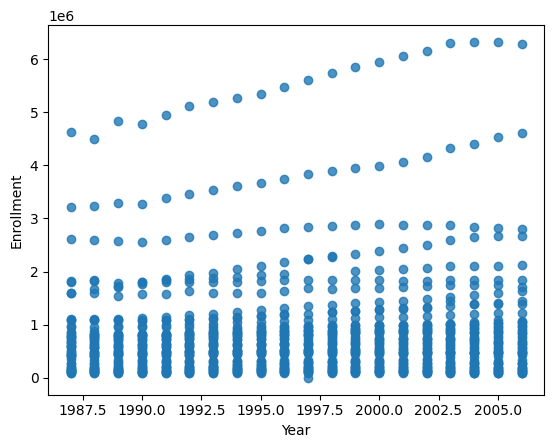

In [33]:
# visualise area-price relationship
sns.regplot(x="Year", y="Enrollment", data=non_county_df, fit_reg=False)

In [35]:
# Select features and target variable
X_slr = non_county_df[['Year']]
y_slr = non_county_df['Enrollment']

X_mlr = non_county_df.drop(['Enrollment', 'Division'] + ['Division ' + str(i) for i in range(2, 9)], axis=1)
y_mlr = non_county_df['Enrollment']

# Fit the models
slr_model = LinearRegression()
mlr_model = LinearRegression()

slr_cv_score = cross_val_score(slr_model, X_slr, y_slr, cv=5, scoring='neg_mean_squared_error')
mlr_cv_score = cross_val_score(mlr_model, X_mlr, y_mlr, cv=5, scoring='neg_mean_squared_error')

# Print cross-validation scores
print("SLR Cross-Validation Mean Squared Error:", -slr_cv_score.mean())
print("MLR Cross-Validation Mean Squared Error:", -mlr_cv_score.mean())

SLR Cross-Validation Mean Squared Error: 996547019130.4246
MLR Cross-Validation Mean Squared Error: 952716623906.0397


In [70]:
# split into X and y for both train and test sets
# reshaping is required since sklearn requires the data to be in shape
# (n, 1), not as a series of shape (n, )

#create response and new predictor
non_county_df['log_Year'] = np.log(non_county_df['Year'])
non_county_df['log_Enrollment'] = np.log(non_county_df['Enrollment'])
slr_fit = linear_model.LinearRegression() #Create a reg object
slr_fit.fit(non_county_df['Year'].values.reshape(-1,1), non_county_df['Enrollment'].values)
print(slr_fit.intercept_, slr_fit.coef_)


X_train, X_test, y_train, y_test = train_test_split(
  non_county_df[['Year', 'Division 2', 'Division 3', 'Division 4', 'Division 5', 'Division 6','Division 7','Division 8','Division 9']],
  non_county_df['Enrollment'],
  test_size=0.20,
  random_state=42)

features = ['Division 2', 'Division 3', 'Division 4', 'Division 5', 'Division 6','Division 7','Division 8','Division 9']
target = 'Enrollment'
#mlr_fit = linear_model.LinearRegression()
#mlr_fit.fit(non_county_df[features], non_county_df[target].values)

mlr_fit = linear_model.LinearRegression().fit(X_train[['Year','Division 2', 'Division 3', 'Division 4', 'Division 5', 'Division 6','Division 7','Division 8','Division 9']], y_train)
slr_fit = linear_model.LinearRegression().fit(X_train['Year'].values.reshape(-1,1), y_train)
cat_fit = linear_model.LinearRegression().fit(X_train['Division 2'].values.reshape(-1,1), y_train)

np.sqrt(mean_squared_error(y_test, mlr_fit.predict(X_test[['Year','Division 2', 'Division 3', 'Division 4', 'Division 5', 'Division 6','Division 7','Division 8','Division 9']])))
np.sqrt(mean_squared_error(y_test, slr_fit.predict(X_test['Year'].values.reshape(-1,1))))
np.sqrt(mean_squared_error(y_test, cat_fit.predict(X_test['Division 2'].values.reshape(-1,1))))

-20991488.776143506 [10959.91395677]


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


983318.974083819

Text(0, 0.5, 'Enrollment')

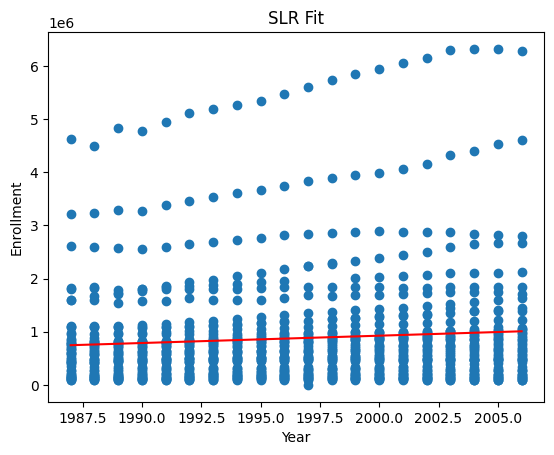

In [71]:
preds = slr_fit.predict(non_county_df['Year'].values.reshape(-1,1))
plt.scatter(non_county_df['Year'].values.reshape(-1,1), non_county_df['Enrollment'].values)
plt.plot(non_county_df['Year'].values.reshape(-1,1), preds, 'red')
plt.title("SLR Fit")
plt.xlabel('Year')
plt.ylabel('Enrollment')

In [72]:
# fit multiple polynomial features
degrees = [1, 2, 3]

# initialise y_train_pred and y_test_pred matrices to store the train and test predictions
# each row is a data point, each column a prediction using a polynomial of some degree
y_train_pred = np.zeros((len(X_train), len(degrees)))
y_test_pred = np.zeros((len(X_test), len(degrees)))

for i, degree in enumerate(degrees):

    # make pipeline: create features, then feed them to linear_reg model
    model = make_pipeline(PolynomialFeatures(degree), LinearRegression())
    model.fit(X_train, y_train)

    # predict on test and train data
    # store the predictions of each degree in the corresponding column
    y_train_pred[:, i] = model.predict(X_train)
    y_test_pred[:, i] = model.predict(X_test)


ValueError: x and y must be the same size

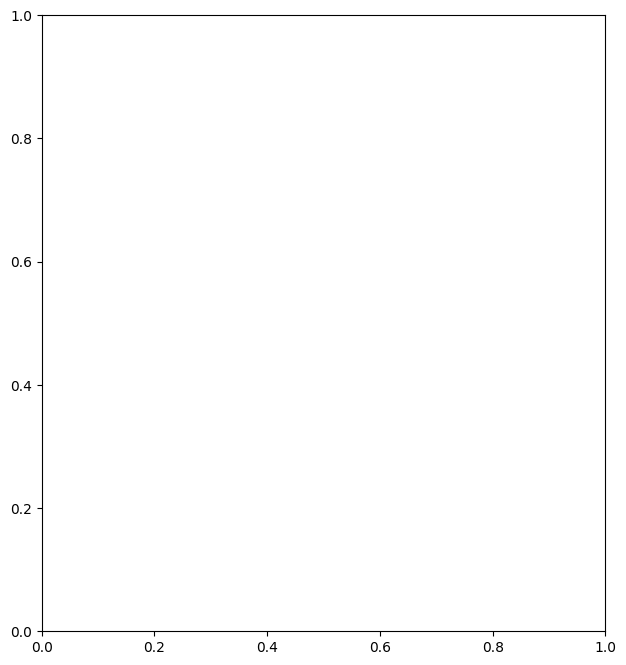

In [73]:
# visualise train and test predictions
# note that the y axis is on a log scale

plt.figure(figsize=(16, 8))

# train data
plt.subplot(121)
plt.scatter(X_train, y_train)
plt.yscale('log')
plt.title("Train data")
for i, degree in enumerate(degrees):
    plt.scatter(X_train, y_train_pred[:, i], s=15, label=str(degree))
    plt.legend(loc='upper left')

# test data
plt.subplot(122)
plt.scatter(X_test, y_test)
plt.yscale('log')
plt.title("Test data")
for i, degree in enumerate(degrees):
    plt.scatter(X_test, y_test_pred[:, i], label=str(degree))
    plt.legend(loc='upper left')

In [ ]:
def sequential_cross_validation(X, y, start_year):
    """
    Perform sequential cross-validation for a linear regression model.

    Parameters:
    - X: Feature matrix
    - y: Target variable
    - start_year: The starting year for cross-validation

    Returns:
    - overall_mse: Overall Mean Squared Error for the model
    """
    # Initialize overall MSE value
    overall_mse = 0

    # Initialize the linear regression model
    model = LinearRegression()

    # Loop through the years for cross-validation
    for year in range(start_year, int(X.loc['year'].max())):
        # df the data into training and testing sets
        X_train = X[X['year'] <= year]
        y_train = y[X['year'] <= year]
        X_test = X[X['year'] == year + 1]
        y_test = y[X['year'] == year + 1]

        # Fit the model on the training data
        model.fit(X_train, y_train)

        # Make predictions on the test set
        y_pred = model.predict(X_test)

        # Calculate the mean squared error for this step
        mse = mean_squared_error(y_test, y_pred)

        # Add the MSE for this step to the overall MSE
        overall_mse += mse

    return overall_mse

# Example usage:
# Assuming X_slr, y_slr, X_mlr, and y_mlr are the feature and target variables for SLR and MLR models
# Adjust these based on your actual data and features

j = 3
for i in range (0,20) :
   non_county_df.loc[:i]


features = ['Division 2', 'Division 3', 'Division 4', 'Division 5', 'Division 6','Division 7','Division 8','Division 9']
target = 'Enrollment'

X_slr_train, X_slr_test, y_slr_train, y_slr_test = train_test_split(
  non_county_df[['Year']],
  non_county_df[target],
  test_size=0.20,
  random_state=42)

X_mlr_train, X_mlr_test, y_mlr_train, y_mlr_test = train_test_split(
  non_county_df[['Year','Division 2', 'Division 3', 'Division 4', 'Division 5', 'Division 6','Division 7','Division 8','Division 9']],
  non_county_df[target],
  test_size=0.20,
  random_state=42)




# Run SLR sequential cross-validation
slr_overall_mse = sequential_cross_validation(X_slr_train, y_slr_train, start_year=1989)

# Run MLR sequential cross-validation
mlr_overall_mse = sequential_cross_validation(X_mlr_train, y_mlr_train, start_year=1989)

# Print overall MSE values
print("SLR Overall Cross-Validation MSE:", slr_overall_mse)
print("MLR Overall Cross-Validation MSE:", mlr_overall_mse)

In [57]:
non_county_df.head()

,Year,Division,Enrollment,Division 2,Division 3,Division 4,Division 5,Division 6,Division 7,Division 8,Division 9,log_Year,log_Enrollment
1,1987,Division 6,733735,0,0,0,0,1,0,0,0,7.594381,13.505903
2,1987,Division 9,102872,0,0,0,0,0,0,0,1,7.594381,11.541241
3,1987,Division 8,609411,0,0,0,0,0,0,1,0,7.594381,13.320248
4,1987,Division 7,429260,0,0,0,0,0,1,0,0,7.594381,12.969818
5,1987,Division 9,4621126,0,0,0,0,0,0,0,1,7.594381,15.346149


In [50]:
non_county_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 960 entries, 1 to 1059
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Year            960 non-null    int64  
 1   Division        960 non-null    object 
 2   Enrollment      960 non-null    int64  
 3   Division 2      960 non-null    uint8  
 4   Division 3      960 non-null    uint8  
 5   Division 4      960 non-null    uint8  
 6   Division 5      960 non-null    uint8  
 7   Division 6      960 non-null    uint8  
 8   Division 7      960 non-null    uint8  
 9   Division 8      960 non-null    uint8  
 10  Division 9      960 non-null    uint8  
 11  log_Year        960 non-null    float64
 12  log_Enrollment  960 non-null    float64
dtypes: float64(2), int64(2), object(1), uint8(8)
memory usage: 52.5+ KB


In [74]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

def calculate_mse_for_one_step(X, Y, last_year):
    # df the data into training and testing sets
    #X_train, X_test = X[X['Year'] <= last_year], X[X['Year'] == last_year + 1]
    #y_train, y_test = Y[X['Year'] <= last_year], Y[X['Year'] == last_year + 1]

    # df the data into training and testing sets
    X_train = X[X['Year'] <= last_year].copy()
    Y_train = Y[X['Year'] <= last_year].copy()
    X_test = X[X['Year'] == last_year + 1].copy()
    Y_test = Y[X['Year'] == last_year + 1].copy()

    model = LinearRegression()
    model.fit(X_train, Y_train)
    # Make predictions and calculate MSE
    predictions = model.predict(X_test)
    mse = mean_squared_error(Y_test, predictions)

    return mse

def cross_validate(X, Y, first_year):
    if first_year < 1989:
        raise ValueError("First year should be 1989 or later.")

    last_year = X['Year'].max()

    mse_total = 0

    for year in range(first_year, last_year):
        mse_total += calculate_mse_for_one_step(X, Y, year)

    return mse_total

# Example usage:
# Assuming X is your predictor data frame and y is your response variable
# Replace X and y with your actual data
X_mlr = non_county_df[['Year', 'Division 2', 'Division 3', 'Division 4', 'Division 5', 'Division 6','Division 7','Division 8','Division 9']]
X_slr = non_county_df[['Year']]
Y_mlr = non_county_df['Enrollment']
Y_slr = non_county_df['Enrollment']

cv_mlr_mse = cross_validate(X_mlr, Y_mlr, first_year=1989)
print("Cross-Validated MSE:", cv_mlr_mse)
cv_slr_mse = cross_validate(X_slr, Y_slr, first_year=1989)
print("Cross-Validated MSE:", cv_slr_mse)


Cross-Validated MSE: 13194470943789.549
Cross-Validated MSE: 17764015721238.176
